min max
[0.7856476  0.97327566] [0.7867339 0.9739029]
3.30M Parameters


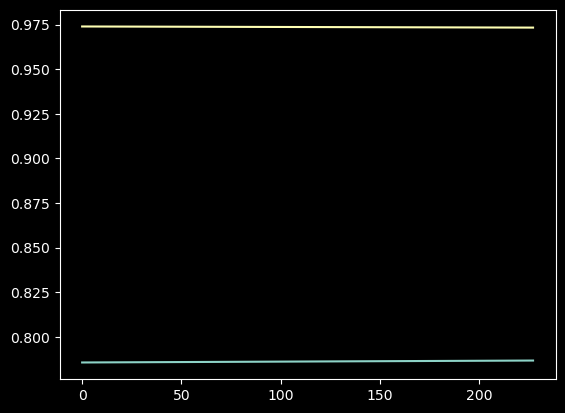

In [8]:
PATH = "/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/0-RPE-cell-timelapse/"
from modules.learning.models import *
from modules.learning.train import train_model
from modules.utils import hc
from modules.visualize import plot_loss, plot_normalized_time_error

# from modules.learning.evaluate import Evaluation, get_latent_space, plot_umap
from matplotlib import pyplot as plt
from modules.learning.dycep import DYCEP
import json

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# enet = EfficientNet()
model = DYCEP()
model.to(DEVICE)

track_path = PATH + "track_datasets/control_mm/train/images/"
label_path = PATH + "track_datasets/control_mm/train/labels/"

#########
# test on one track
#########

track_name = "0607.1629.npy"
# getting one sequence to check the model
imgs = torch.tensor(
    np.load(track_path + track_name, allow_pickle=True),
    dtype=torch.float32,
)[:, [1], :, :]


label = torch.tensor(
    np.load(label_path + track_name).reshape(2, -1).T,
    dtype=torch.float32,
)

imgs, label = imgs.to(DEVICE), label.to(DEVICE)

zz = model.forward(imgs[None, :, :, :])
zz = zz.detach().cpu().numpy().squeeze()
plt.plot(zz)
print("min max")
print(zz.min(0), zz.max(0))
print(hc(model), "Parameters")

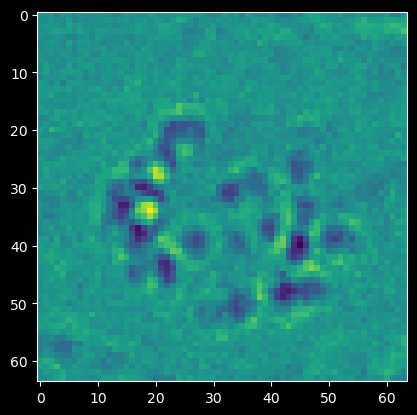

In [30]:
imgs.shape
imgs = torch.tensor(
    np.load(track_path + track_name, allow_pickle=True),
    dtype=torch.float32,
)[:, :, :, :]

plt.imshow(imgs[50, 1, :, :].detach().cpu().numpy())

[1]

dict_keys(['number', 'path', 'name', 'model_type', 'img_channels', 'batch_size', 'num_epochs', 'learning_rate', 'train_loss', 'test_loss', 'train_R2', 'test_R2'])


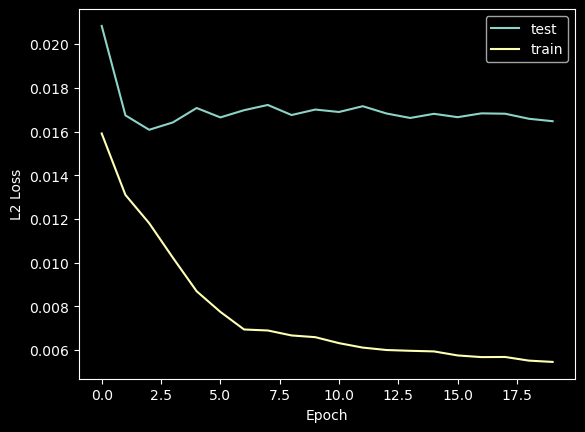

In [21]:
model_number = 32

conf_path = f"weights/config-{model_number}.json"

# load dict in .json file
with open(conf_path, "r") as file:
    config = json.load(file)

img_channel = config['img_channels']

print(config.keys())
plt.plot(config["test_loss"], label="test")
plt.plot(config["train_loss"], label="train")

plt.ylabel("L2 Loss")
plt.xlabel("Epoch")

plt.legend()

dict_keys(['number', 'path', 'name', 'model_type', 'img_channels', 'batch_size', 'num_epochs', 'learning_rate', 'train_loss', 'test_loss', 'train_R2', 'test_R2'])


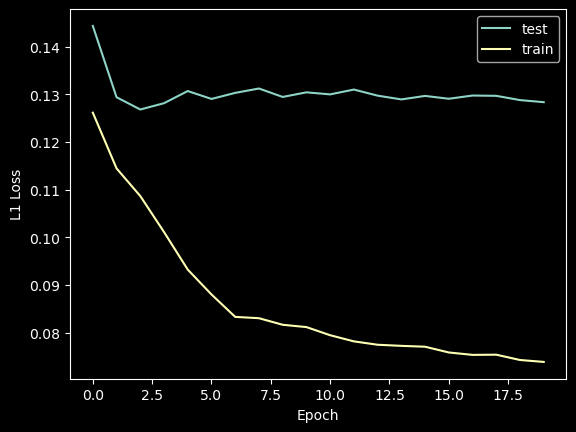

In [22]:
print(config.keys())

l1_train = np.sqrt(config["train_loss"])
l1_test = np.sqrt(config["test_loss"])

plt.plot(l1_test, label="test")
plt.plot(l1_train, label="train")

plt.ylabel("L1 Loss")
plt.xlabel("Epoch")

plt.legend()

In [23]:
from modules.learning.evaluate import Evaluation


model.load_state_dict(torch.load(f"weights/model-{model_number}.pt"))

eval = Evaluation()
eval.fit(
    PATH + "track_datasets/control_mm/test/", model, img_channels=img_channel, smoothing=True
)

2024-12-03 11:47:03.106590: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 11:47:03.714262: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
100%|██████████| 358/358 [00:07<00:00, 48.00it/s]


----------------------------------------------------------------------
Model Performance:
\ell_1: 0.074 ± 0.030
\ell_2: 0.016 ± 0.018
W_d: 0.058 ± 0.021
Accuracy: 0.891 ± 0.074



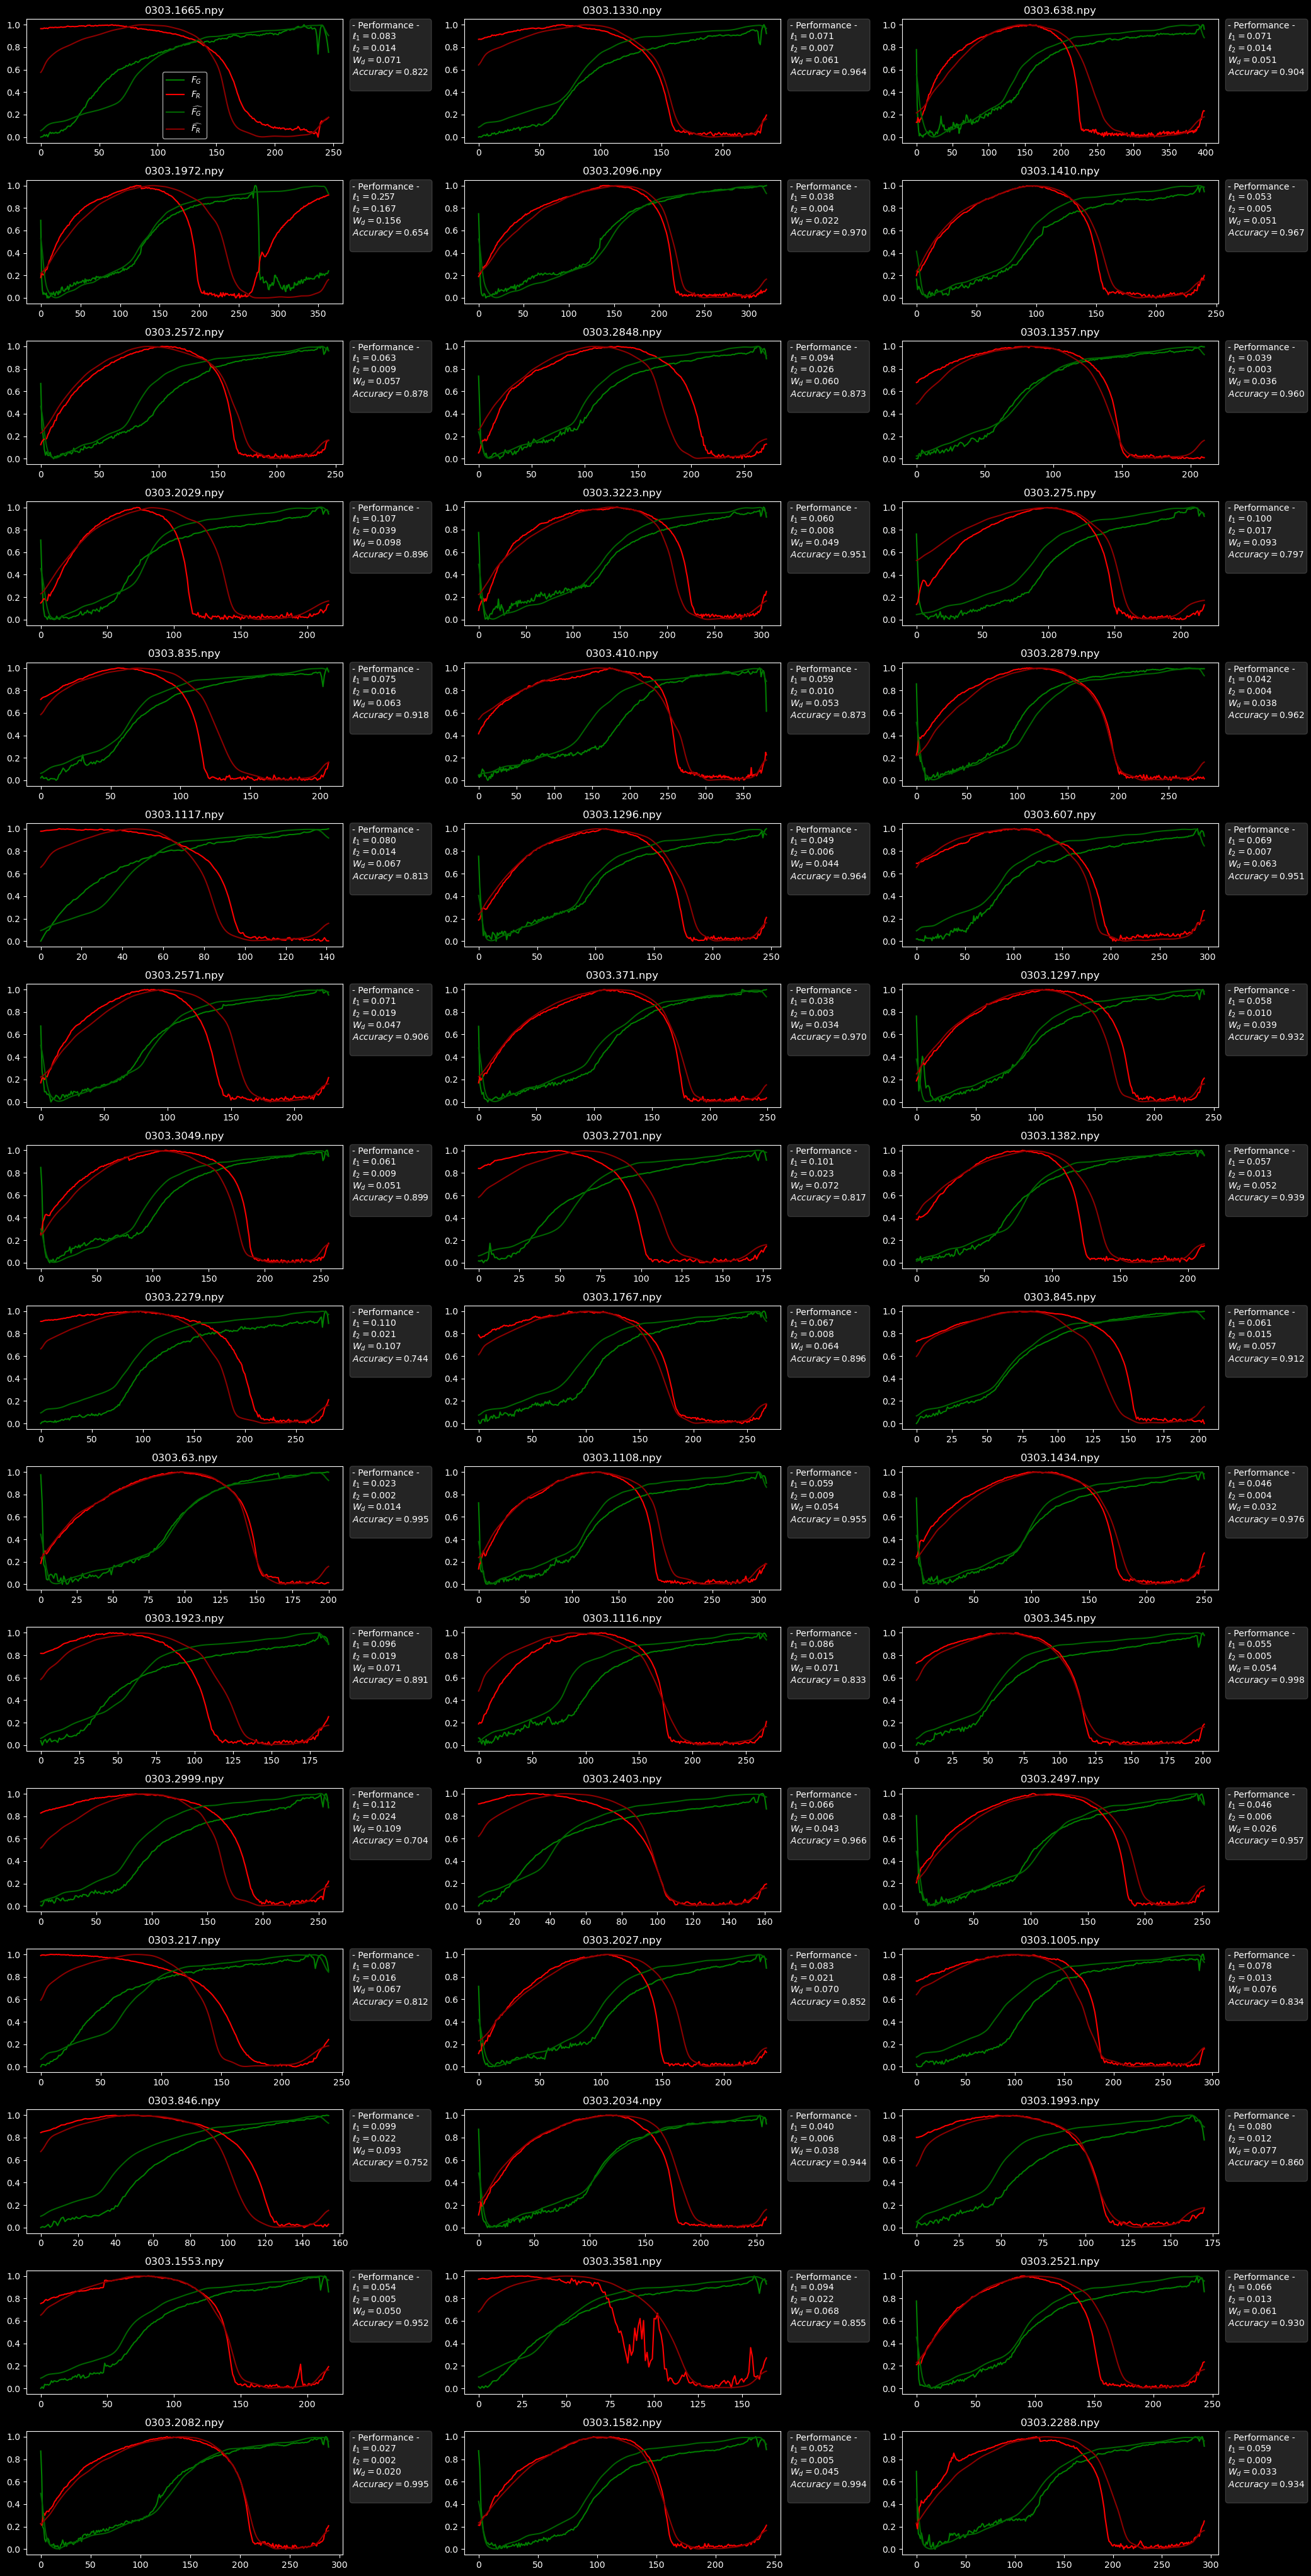

In [24]:
print(eval.summary())
eval.visualize_predicted_tracks(50)

In [25]:
eval.prediction_df.columns


Index(['CELL_ID', 'y', 'y_hat', '\ell_1', '\ell_2', 'W_d', 'Accuracy'], dtype='object')

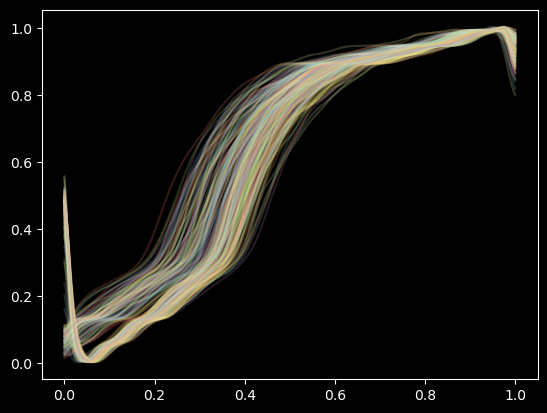

In [26]:
for i in range(200):
    track = eval.prediction_df.y_hat[i]
    tau = np.linspace(0, 1, track.shape[0])
    plt.plot(tau, track[:, 0], alpha=0.2)

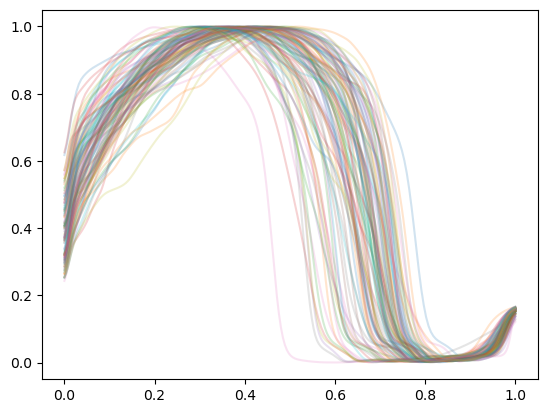

In [14]:
for i in range(100):
    track = eval.prediction_df.y_hat[i]
    tau = np.linspace(0, 1, track.shape[0])
    plt.plot(tau, track[:, 1], alpha=0.2)

# get phases

In [15]:
import os
from tqdm import tqdm

In [16]:
img_directory = PATH + "track_datasets/control_mm/test/images/"
cells = os.listdir(img_directory)[:]
# Initialize pandas cells so we can store tracks inside
# model.to(DEVICE)

ph = []
for idx, cell in enumerate(tqdm(cells)):
    # Get input with specific image channels and groundtruth FUCCI signal
    x = (
        torch.tensor(
            np.load(img_directory + cell, allow_pickle=True),
            dtype=torch.float32,
        )[:, [1], :, :]
        .unsqueeze(0)
        .to(DEVICE)
    )

    x = model.spatial_encoder(x)
    x = model.temporal_encoder(model.fc_s2t(x))
    x = model.get_phi(x)

    ph.append(x.detach().cpu().numpy().squeeze())

100%|██████████| 358/358 [00:05<00:00, 68.18it/s]


In [24]:
ph0 = [p[0] for p in ph]
ph_fn = [p[-1] for p in ph]

print(f"ph 0 mean {np.mean(ph0)} std {np.std(ph0)}")
print(f"ph fin mean {np.mean(ph_fn)} std {np.std(ph_fn)}")
print(f"ph 0 min {np.min(ph0)} max {np.max(ph0)}")
print(f"ph fin min {np.min(ph_fn)} max {np.max(ph_fn)}")


ph 0 mean 0.009439577348530293 std 0.018200203776359558
ph fin mean 0.9968457818031311 std 0.0006021166336722672
ph 0 min 2.9136128887330415e-06 max 0.0748598501086235
ph fin min 0.9945963621139526 max 0.9982221722602844


Text(0.5, 0, 'Normalized Time')

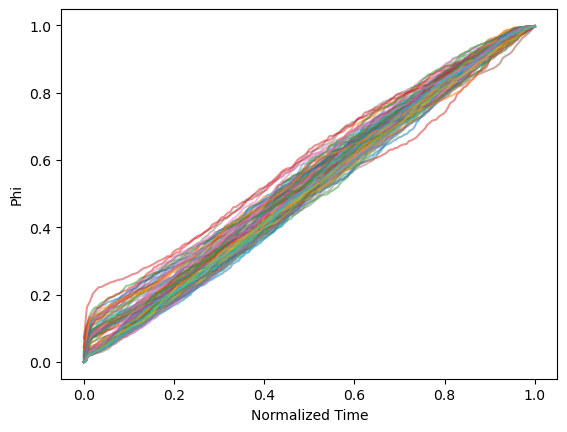

In [21]:
for i in range(100):
    plt.plot(np.linspace(0, 1, len(ph[i])), ph[i], alpha=0.5)

plt.ylabel("Phi")
plt.xlabel("Normalized Time")